In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('../data/prices_round_1_day_-2.csv', delimiter=';')
df.fillna(0, inplace=True)

dfna = pd.read_csv('../data/prices_round_1_day_-2.csv', delimiter=';')

In [2]:
dfna['spread'] = df['ask_price_1'] - df['bid_price_1']

def vwap(row):
    ask_tot = row['ask_price_1'] * row['ask_volume_1'] + row['ask_price_2'] * row['ask_volume_2'] + row['ask_price_3'] * row['ask_volume_3']
    ask_vol = row['ask_volume_1'] + row['ask_volume_2'] + row['ask_volume_3']
    return ask_tot / ask_vol

def vwbp(row):
    bid_tot = row['bid_price_1'] * row['bid_volume_1'] + row['bid_price_2'] * row['bid_volume_2'] + row['bid_price_3'] * row['bid_volume_3']
    bid_vol = row['bid_volume_1'] + row['bid_volume_2'] + row['bid_volume_3']
    return bid_tot / bid_vol

def vwmp(row):
    return (vwap(row) + vwbp(row)) / 2

dfna['mid_price'] = df.apply(vwmp, axis=1)
dfna['vwap'] = df.apply(vwap, axis=1)
dfna['vwbp'] = df.apply(vwbp, axis=1)
dfna['vol'] = df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3'] - (df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3'])

df = dfna

df.head(5)

day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
0   -2          0  AMETHYSTS        10002             1       9996.0   
1   -2          0  STARFRUIT         5002             1       4997.0   
2   -2        100  AMETHYSTS         9996             2       9995.0   
3   -2        100  STARFRUIT         4997            24          NaN   
4   -2        200  STARFRUIT         4997             2       4996.0   

   bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  ask_price_2  \
0           2.0       9995.0          29.0        10004  ...      10005.0   
1          31.0          NaN           NaN         5003  ...          NaN   
2          22.0          NaN           NaN        10004  ...      10005.0   
3           NaN          NaN           NaN         5003  ...       5004.0   
4          20.0          NaN           NaN         5003  ...          NaN   

   ask_volume_2  ask_price_3  ask_volume_3     mid_price  profit_and_loss  \
0          29.0          NaN           NaN  10000.108367         0.000000   
1           NaN          NaN           NaN   5000.078125         0.000000   
2          22.0          NaN           NaN  10000.000000        -4.000000   
3          22.0          NaN           NaN   5000.458333        -2.925293   
4           NaN          NaN           NaN   4999.545455        -3.134766   

   spread          vwap         vwbp  vol  
0       2  10004.935484  9995.281250 -1.0  
1       1   5003.000000  4997.156250 -1.0  
2       8  10004.916667  9995.083333  0.0  
3       6   5003.916667  4997.000000  0.0  
4       6   5003.000000  4996.090909 -2.0  

[5 rows x 21 columns]

<Axes: >

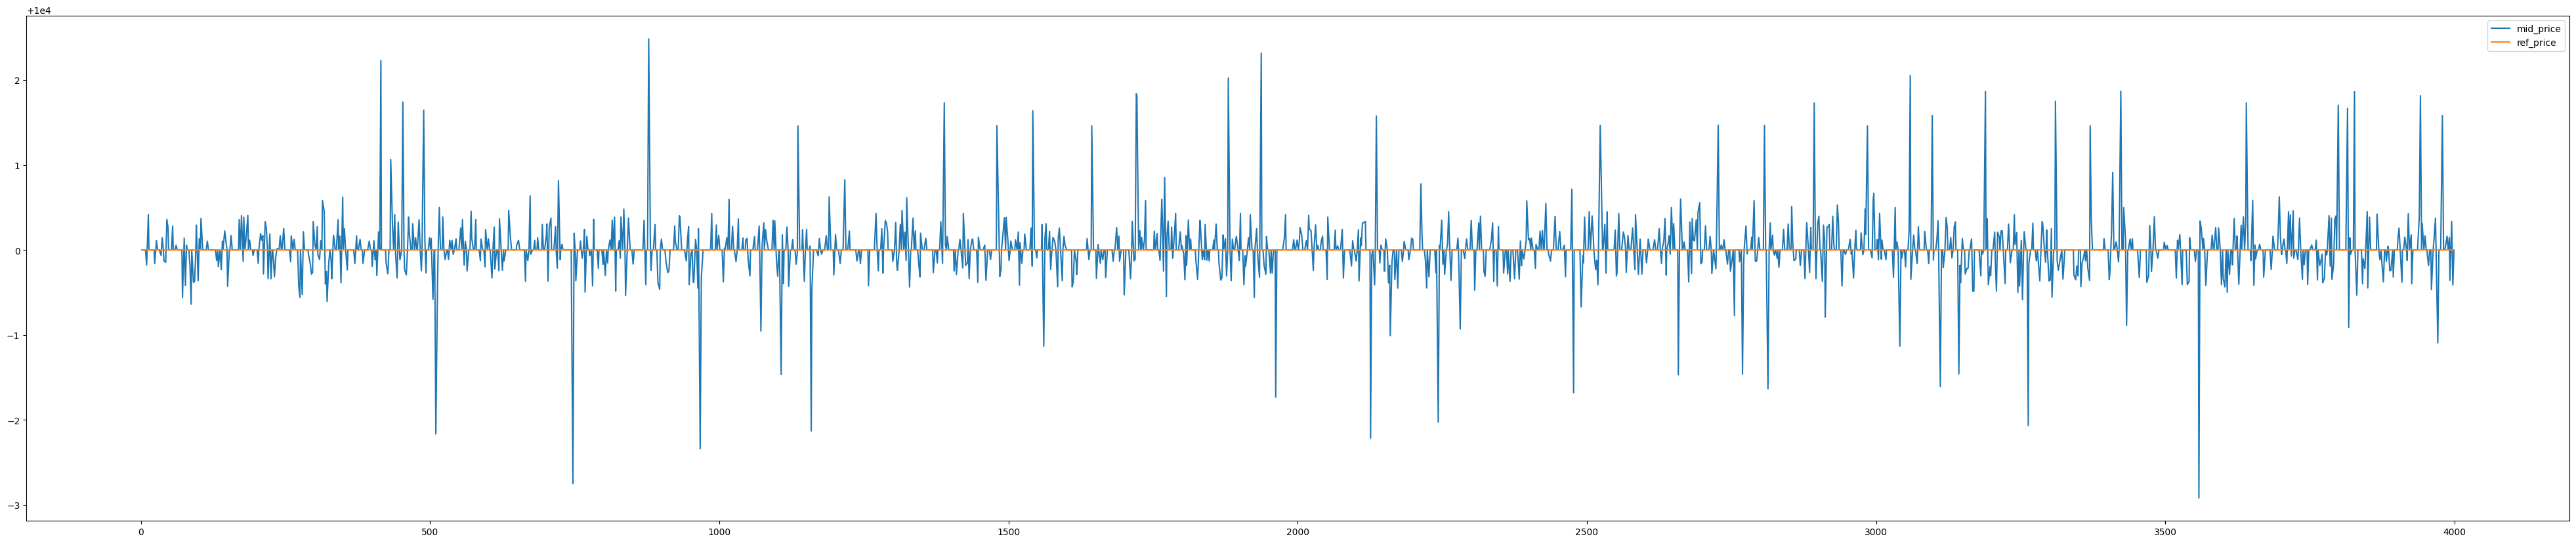

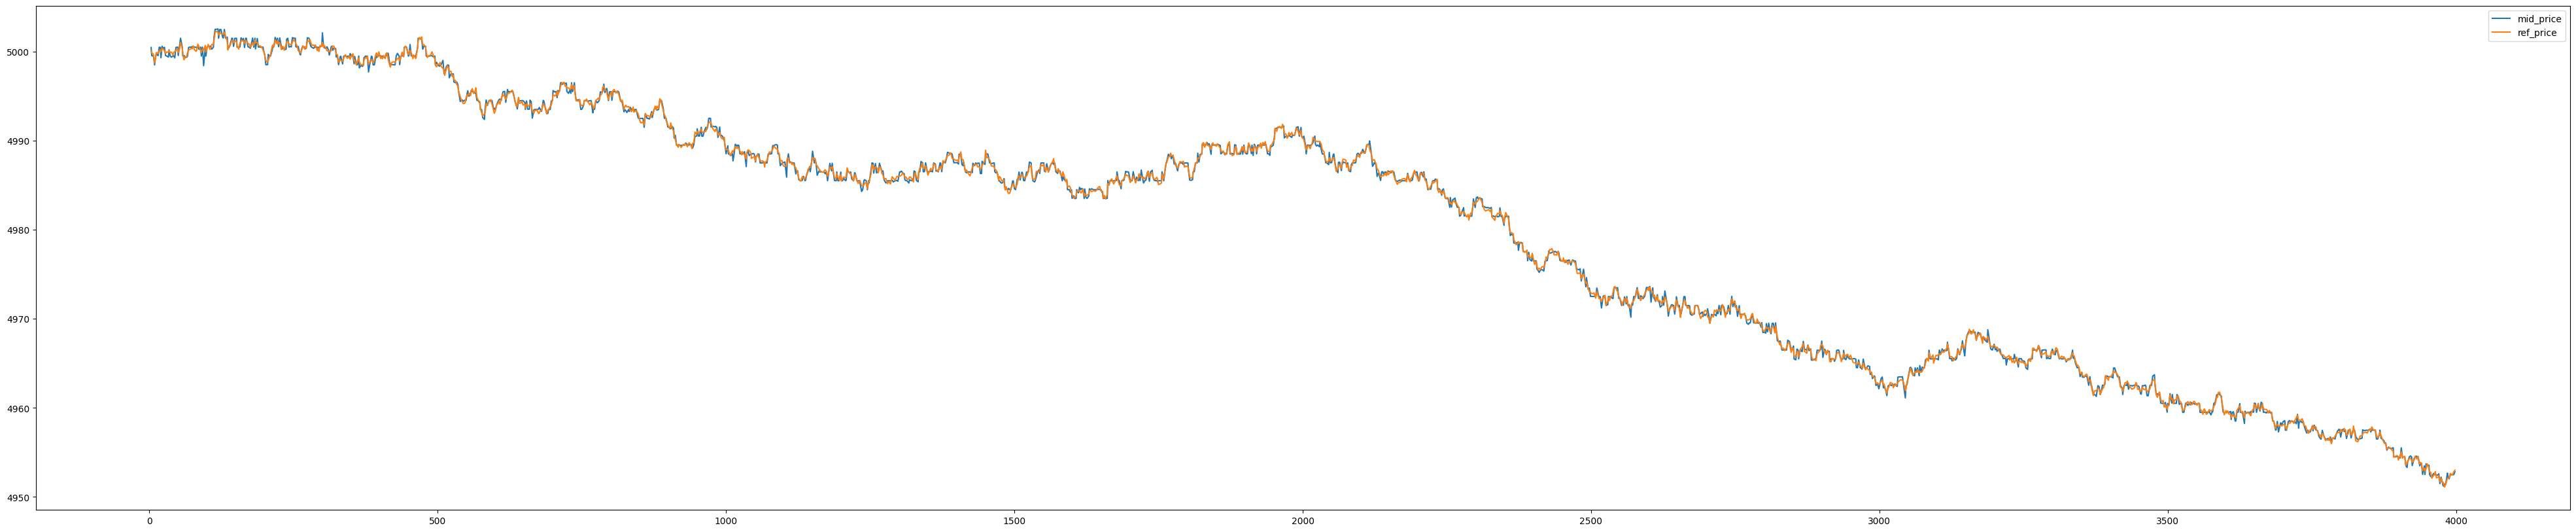

In [3]:
buy_price = {
    'AMETHYSTS': 10004,
    'STARFRUIT': 5003
}

df.loc[df['product'] == 'AMETHYSTS', 'ref_price'] = df[df['product'] == 'AMETHYSTS']['profit_and_loss'] + buy_price['AMETHYSTS']
df.loc[df['product'] == 'STARFRUIT', 'ref_price'] = df[df['product'] == 'STARFRUIT']['profit_and_loss'] + buy_price['STARFRUIT']
df = df.iloc[2:]

df[df['product'] == 'AMETHYSTS'].plot(y=['mid_price','ref_price'], style='-',figsize=(50,10))
df[df['product'] == 'STARFRUIT'].plot(y=['mid_price','ref_price'], style='-',figsize=(50,10))

count    1990.000000
mean       -0.069590
std         0.338106
min        -1.000000
25%        -0.287980
50%        -0.025882
75%         0.130100
max         1.000000
Name: rsi, dtype: float64


/var/folders/mf/f3gnw9hj01q67wmsz9fyz0w40000gn/T/ipykernel_2195/985233797.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['product'] == 'STARFRUIT', 'ema'] = df[df['product'] == 'STARFRUIT']['mid_price'].ewm(span=15, adjust=False).mean()
/var/folders/mf/f3gnw9hj01q67wmsz9fyz0w40000gn/T/ipykernel_2195/985233797.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['product'] == 'STARFRUIT', 'std'] = np.abs(df[df['product'] == 'STARFRUIT']['mid_price'].rolling(100).std())
/var/folders/

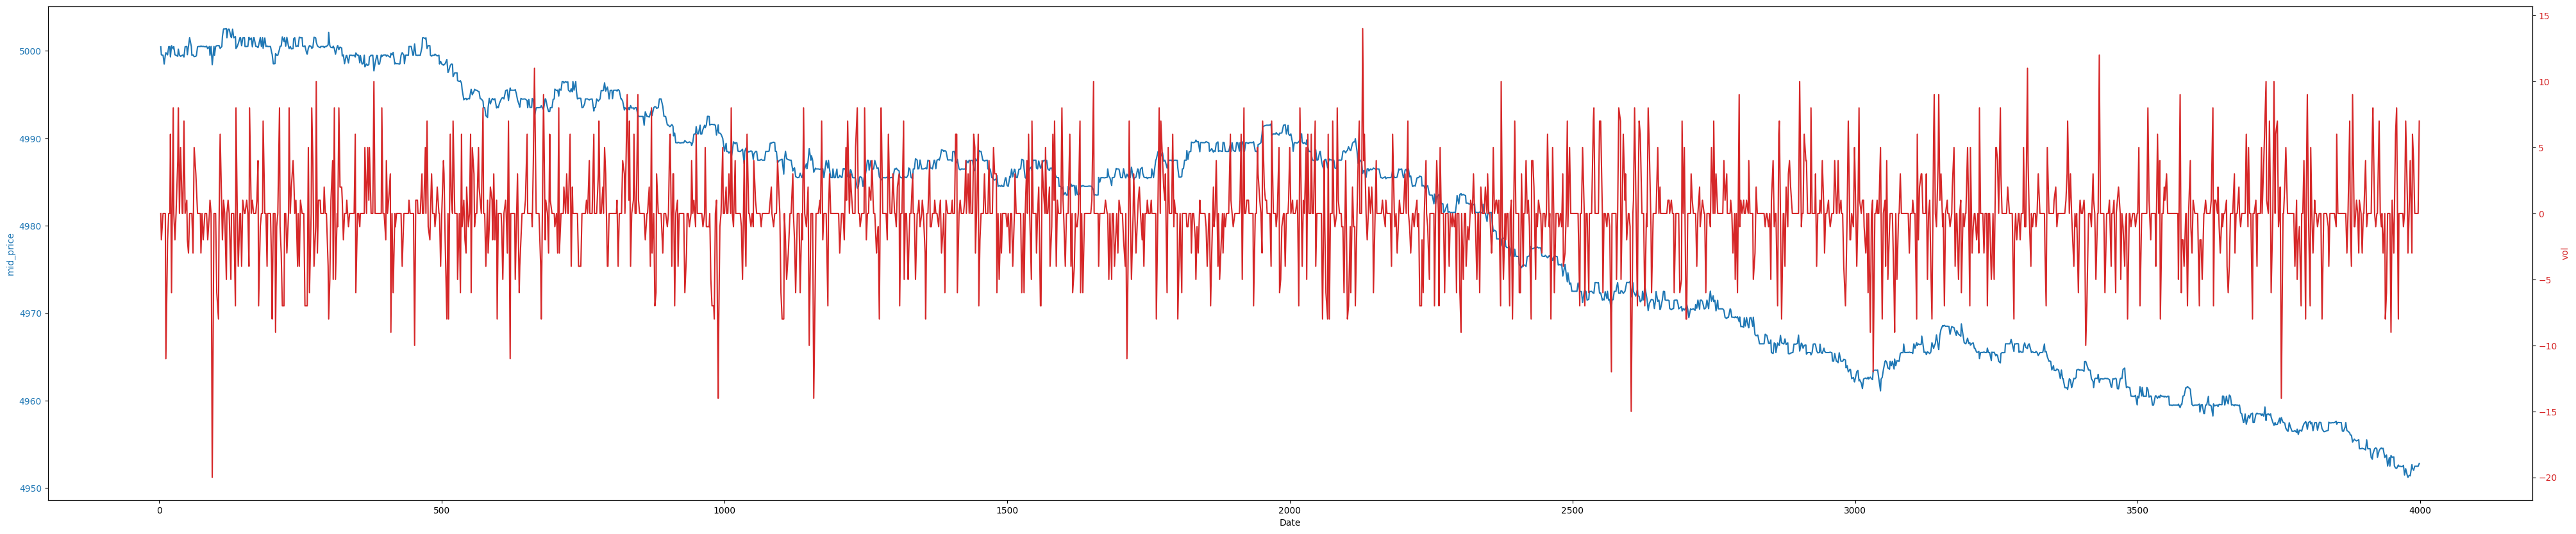

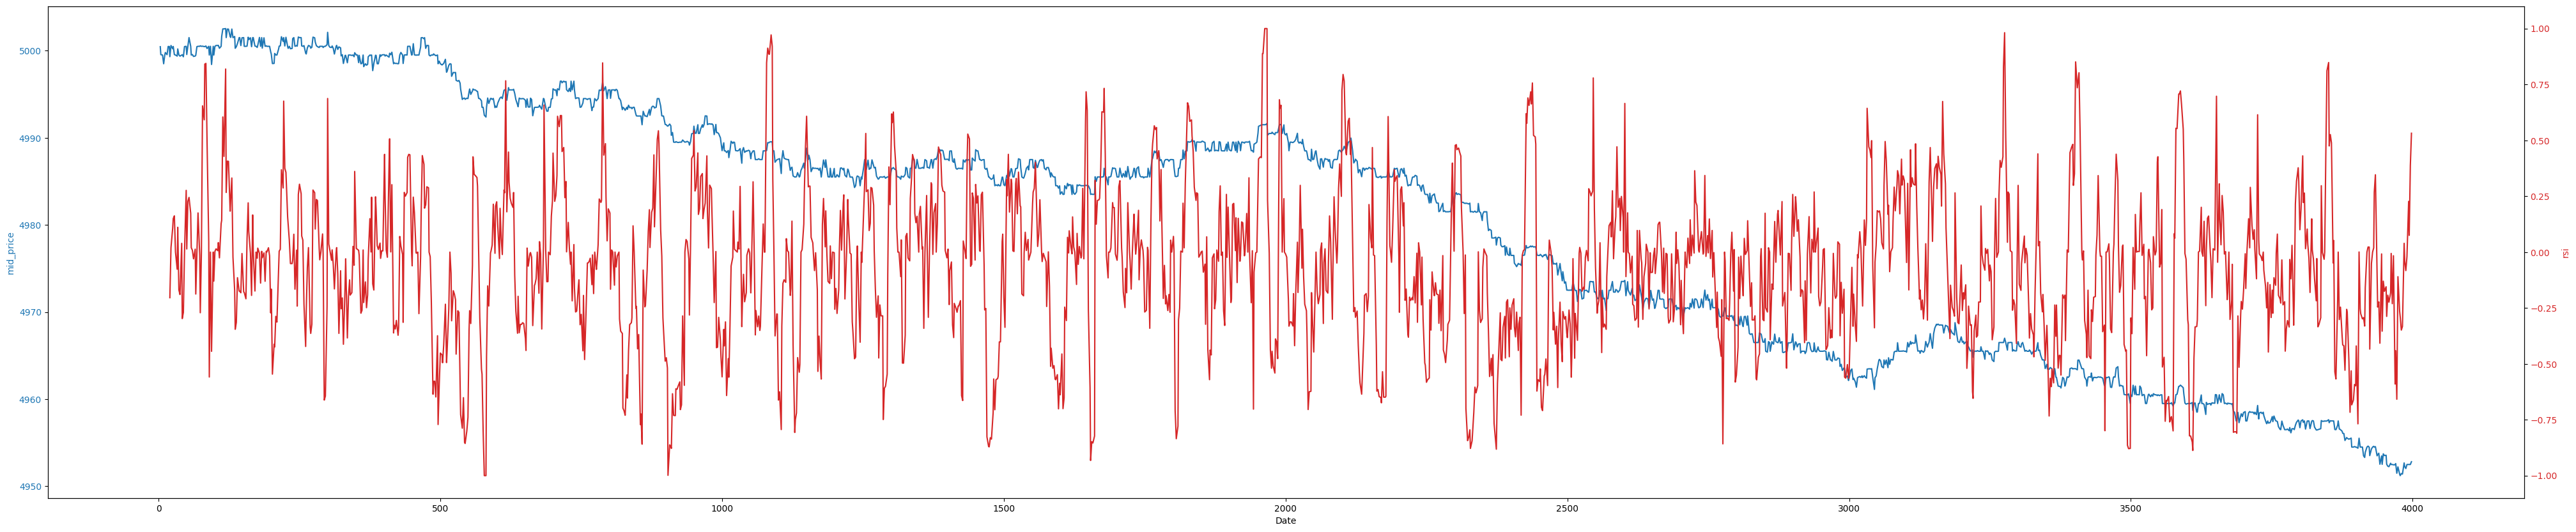

In [4]:
import matplotlib.pyplot as plt

def plot_dual_axis(df, col, col1):
    fig, ax1 = plt.subplots(figsize=(50, 10))

    color1 = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(col, color=color1)
    ax1.plot(df.index, df[col], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel(col1, color=color2)
    ax2.plot(df.index, df[col1], color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.show()


def calculate_rsi(data, column_name, period=10):
    # Calculate daily price changes
    delta = data[column_name].diff(1)

    # Calculate gain (positive price changes) and loss (negative price changes)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate average gain and average loss over the specified period
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    # Calculate relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    # Add RSI to the DataFrame
    return rsi / 50 - 1

df.loc[df['product'] == 'STARFRUIT', 'ema'] = df[df['product'] == 'STARFRUIT']['mid_price'].ewm(span=15, adjust=False).mean()
df.loc[df['product'] == 'STARFRUIT', 'std'] = np.abs(df[df['product'] == 'STARFRUIT']['mid_price'].rolling(100).std())
df.loc[df['product'] == 'STARFRUIT', 'rsi'] = calculate_rsi(df[df['product'] == 'STARFRUIT'], 'mid_price')

print(df[df['product'] == 'STARFRUIT']['rsi'].describe())

plot_dual_axis(df[df['product'] == 'STARFRUIT'], 'mid_price', 'vol')
plot_dual_axis(df[df['product'] == 'STARFRUIT'], 'mid_price', 'rsi')

In [5]:
for i in range(1,21):
    df.loc[df['product'] == 'STARFRUIT', "mid_price.L"+str(i)] = df[df['product'] == 'STARFRUIT']["mid_price"].shift(i)
    df.loc[df['product'] == 'STARFRUIT', "vwap.L"+str(i)] = df[df['product'] == 'STARFRUIT']["vwap"].shift(i)
    df.loc[df['product'] == 'STARFRUIT', "vwbp.L"+str(i)] = df[df['product'] == 'STARFRUIT']["vwbp"].shift(i)

    df.loc[df['product'] == 'AMETHYSTS', "mid_price.L"+str(i)] = df[df['product'] == 'AMETHYSTS']["mid_price"].shift(i)
    df.loc[df['product'] == 'AMETHYSTS', "vwap.L"+str(i)] = df[df['product'] == 'AMETHYSTS']["vwap"].shift(i)
    df.loc[df['product'] == 'AMETHYSTS', "vwbp.L"+str(i)] = df[df['product'] == 'AMETHYSTS']["vwbp"].shift(i)


/var/folders/mf/f3gnw9hj01q67wmsz9fyz0w40000gn/T/ipykernel_2195/4135719602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['product'] == 'STARFRUIT', "mid_price.L"+str(i)] = df[df['product'] == 'STARFRUIT']["mid_price"].shift(i)
/var/folders/mf/f3gnw9hj01q67wmsz9fyz0w40000gn/T/ipykernel_2195/4135719602.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['product'] == 'STARFRUIT', "vwap.L"+str(i)] = df[df['product'] == 'STARFRUIT']["vwap"].shift(i)
/var/folders/mf/f3gnw9hj01q67wmsz9fy

In [39]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

i = 4
feat = ['mid_price.L'+str(k) for k in range(1, i + 1)] + ['mid_price']
#feat = ['vwap.L'+str(k) for k in range(1, i + 1)] + ['vwbp','vwap'] +  ['vwbp.L'+str(k) for k in range(1, i + 1)]
x = df[feat]
y = df['ref_price']
#x = sm.add_constant(x)

model = sm.OLS(y, x, missing='drop').fit()
df['pred_mid_price'] = model.predict(x)
df.loc[df['product'] == 'STARFRUIT', 'buy'] = np.where(df[df['product'] == 'STARFRUIT']['pred_mid_price'] >= df[df['product'] == 'STARFRUIT']['ask_price_1'], df[df['product'] == 'STARFRUIT']['ask_price_1'], np.nan)
df.loc[df['product'] == 'STARFRUIT', 'sell'] = np.where(df[df['product'] == 'STARFRUIT']['pred_mid_price'] <= df[df['product'] == 'STARFRUIT']['bid_price_1'], df[df['product'] == 'STARFRUIT']['bid_price_1'], np.nan)

print(i, model.summary())
print(model.params)

df[df['product'] == 'STARFRUIT'].plot(y=['ask_price_1', 'bid_price_1', 'ask_price_2', 'bid_price_2', 'ask_price_3', 'bid_price_3', 'pred_mid_price','ref_price', 'buy', 'sell'], style=['-','-','-','-','-','-','-','-', 'go', 'ro'],figsize=(100,10))
plt.show()
(df[df['product'] == 'STARFRUIT']['pred_mid_price'] - df[df['product'] == 'STARFRUIT']['ref_price']).plot(figsize=(30,10))
plt.show()

residuals = df[df['product'] == 'STARFRUIT']['pred_mid_price'] - df[df['product'] == 'STARFRUIT']['ref_price']

sns.displot(residuals)
plt.show()
print(residuals.describe())

data = residuals.dropna()
mu, std = norm.fit(data)
# Plot the histogram of the data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Plot the fitted Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

ValueError: Input contains NaN.

/var/folders/mf/f3gnw9hj01q67wmsz9fyz0w40000gn/T/ipykernel_2195/3310456444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_mid_price'] = 10000
/var/folders/mf/f3gnw9hj01q67wmsz9fyz0w40000gn/T/ipykernel_2195/3310456444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['buy'] = np.where(10001 >= df['ask_price_1'], df['ask_price_1'], np.nan)
/var/folders/mf/f3gnw9hj01q67wmsz9fyz0w40000gn/T/ipykernel_2195/3310456444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

<Axes: >

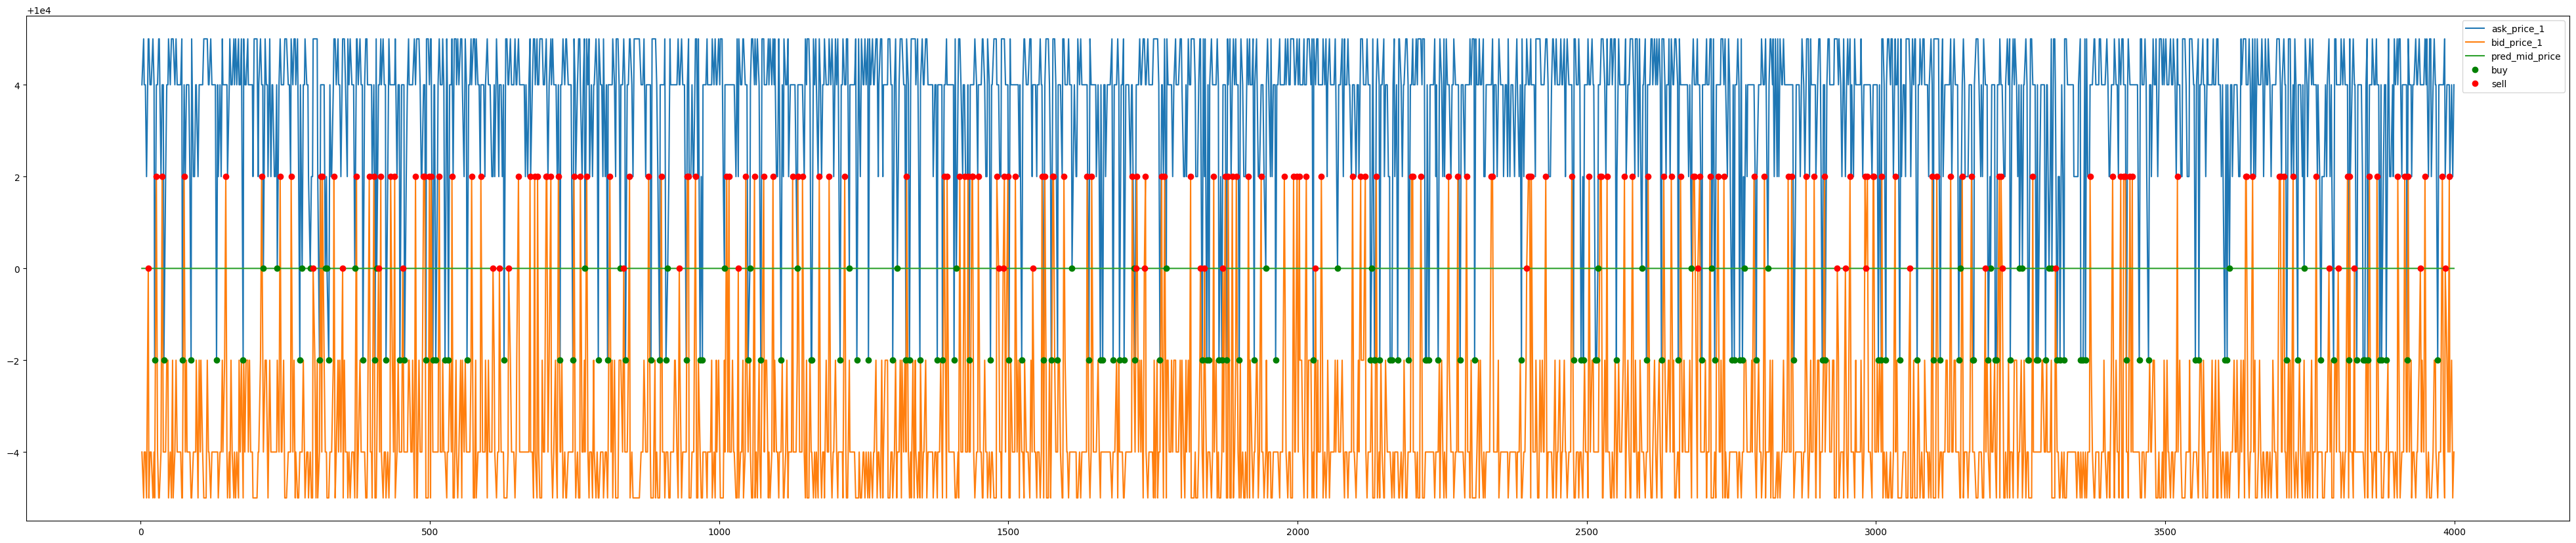

In [7]:
df['pred_mid_price'] = 10000
df['buy'] = np.where(10001 >= df['ask_price_1'], df['ask_price_1'], np.nan)
df['sell'] = np.where(10000 <= df['bid_price_1'], df['bid_price_1'], np.nan)

df[df['product'] == 'AMETHYSTS'].plot(y=['ask_price_1', 'bid_price_1' ,'pred_mid_price', 'buy', 'sell'], style=['-','-','-', 'go', 'ro'],figsize=(50,10))

In [29]:
trades_max = pd.read_json('../data/max.log')
trades_one = pd.read_json('../data/one.log')

AMETHYSTS


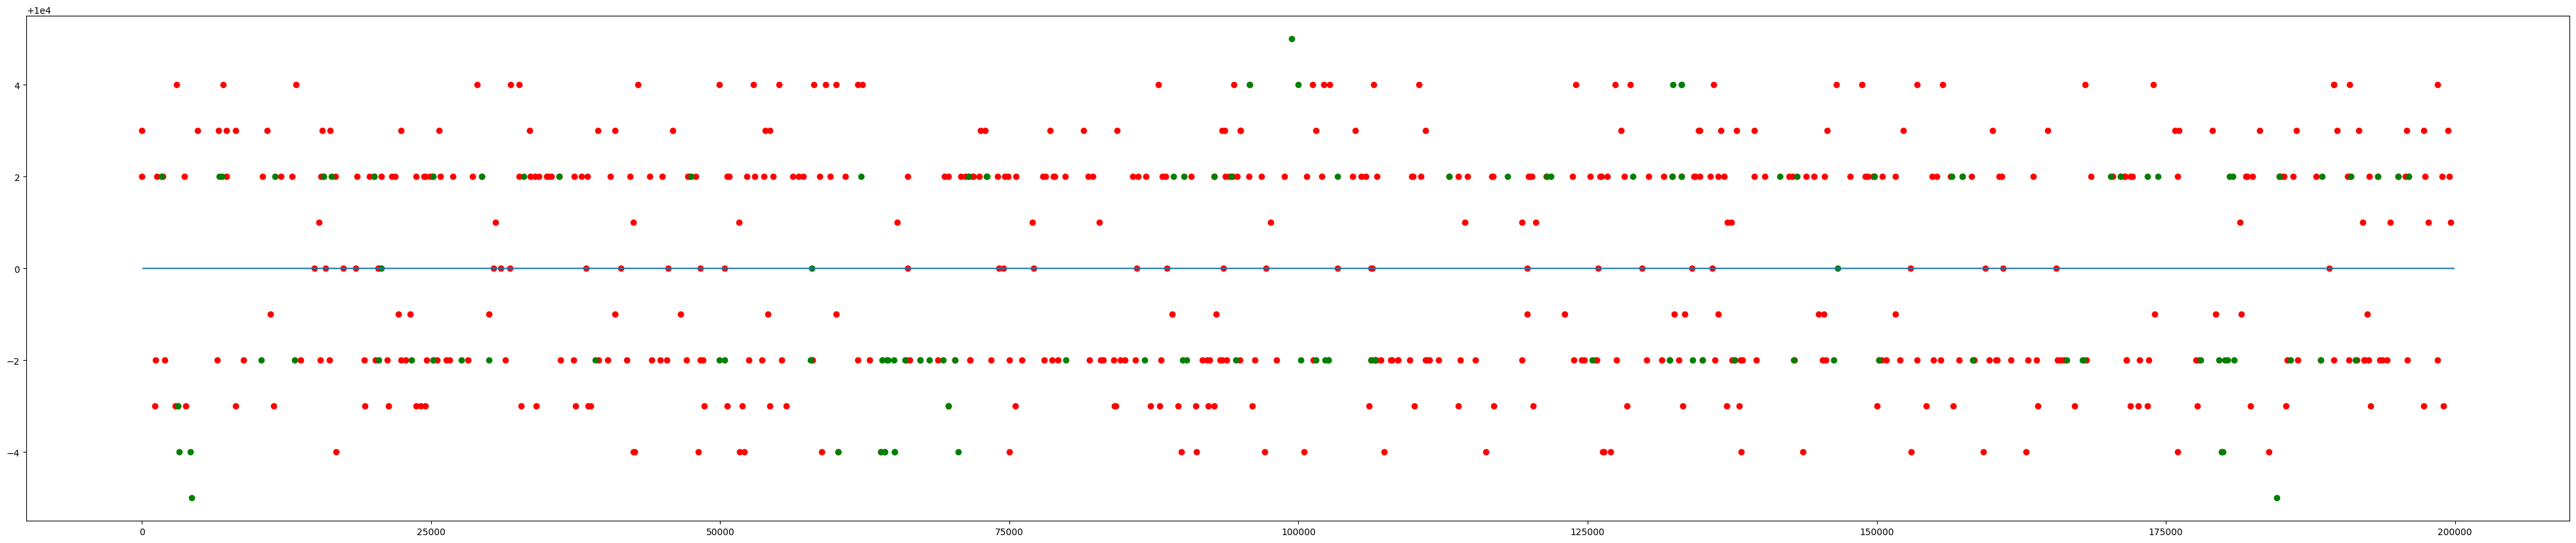

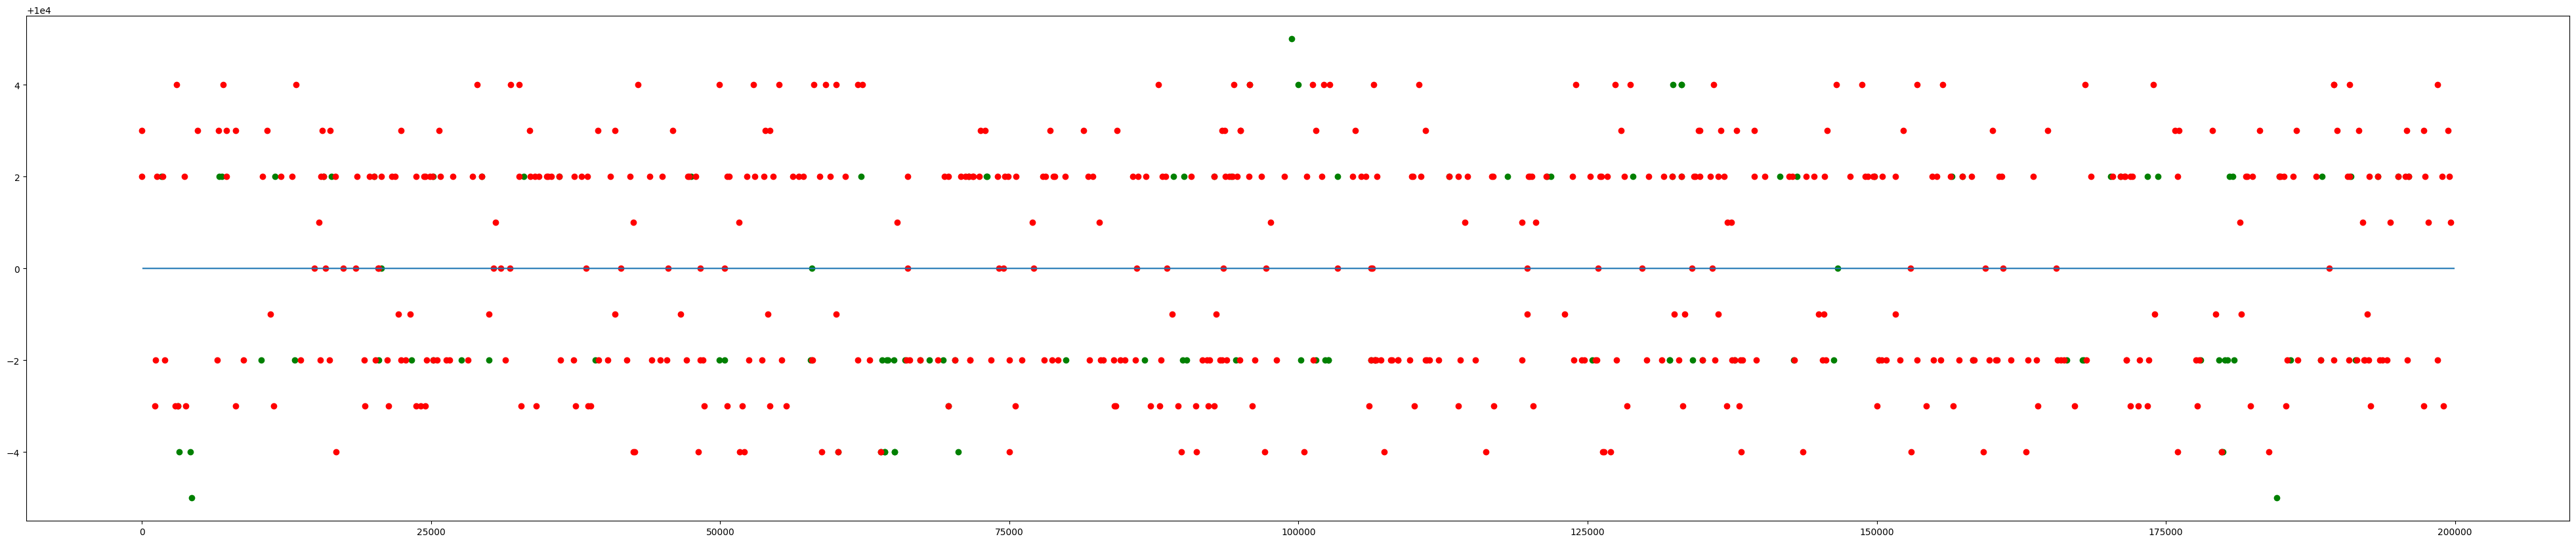

STARFRUIT


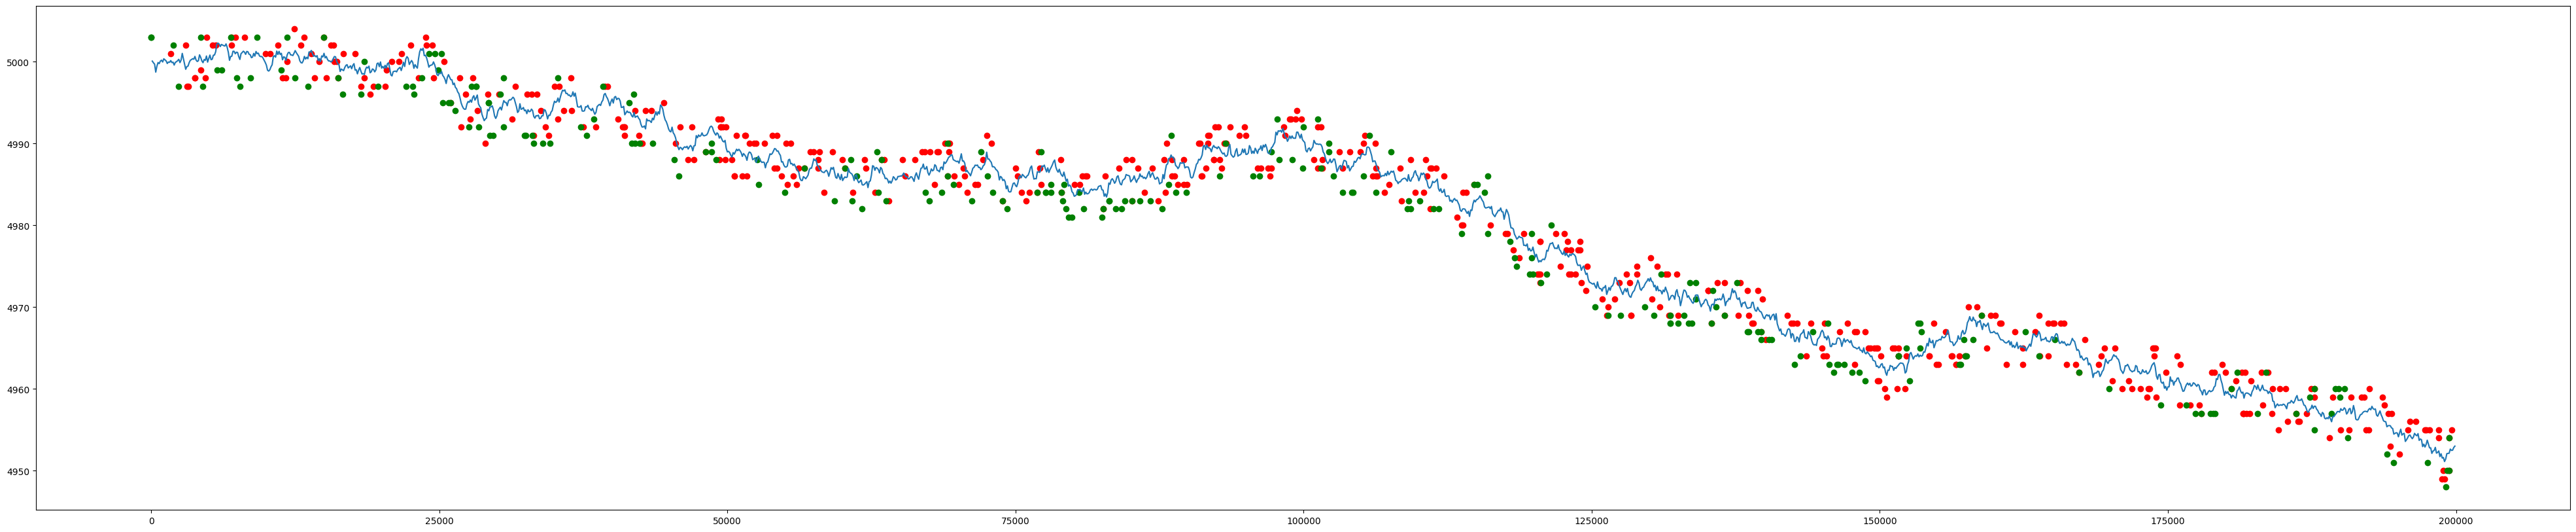

In [36]:
def plot_trades(product):
    ds1 = df[df['product'] == product]
    ds2 = trades_max[(trades_max['symbol'] == product) & ((trades_max['buyer'] == 'SUBMISSION') | (trades_max['seller'] == 'SUBMISSION'))]
    ds3 = trades_max[(trades_max['symbol'] == product) & ((trades_max['buyer'] != 'SUBMISSION') & (trades_max['seller'] != 'SUBMISSION'))]
    #ds3 = trades[(trades['symbol'] == 'STARFRUIT') & ((trades['buyer'] == 'SUBMISSION') | (trades['seller'] == 'SUBMISSION'))]

    print(product)
    _, ax = plt.subplots(figsize=(50, 10))
    ax.plot(ds1.timestamp, ds1.ref_price)
    ax.scatter(ds2.timestamp, ds2.price, color='red')
    ax.scatter(ds3.timestamp, ds3.price, color='green')
    
    plt.show()
    _, ax = plt.subplots(figsize=(50, 10))
    ax.plot(ds1.timestamp, ds1.ref_price)
    ax.scatter(ds3.timestamp, ds3.price, color='green')
    ax.scatter(ds2.timestamp, ds2.price, color='red')
    plt.show()

plot_trades('AMETHYSTS')
plot_trades('STARFRUIT')